In [1]:
import torch
import numpy as np
from Model import Net
from Dataloader import AudioDataset
from helpers import Reconstruct, Viz_Y

import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal


from torch.optim import LBFGS, Adam,SGD
from sklearn.decomposition import NMF
import warnings 

warnings.simplefilter('ignore')

# Read audio file:

In [2]:
samplerate, data = read("../data/mix_signal.wav")
music=data[:200000,0]
length=music.shape[0]/samplerate
print('Shape of the data {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate))

Shape of the data 200000
Length : 4.54s
Sample rate : 44100


# Apply STFT :

## We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size


In [3]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512


f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs=np.abs(Y)

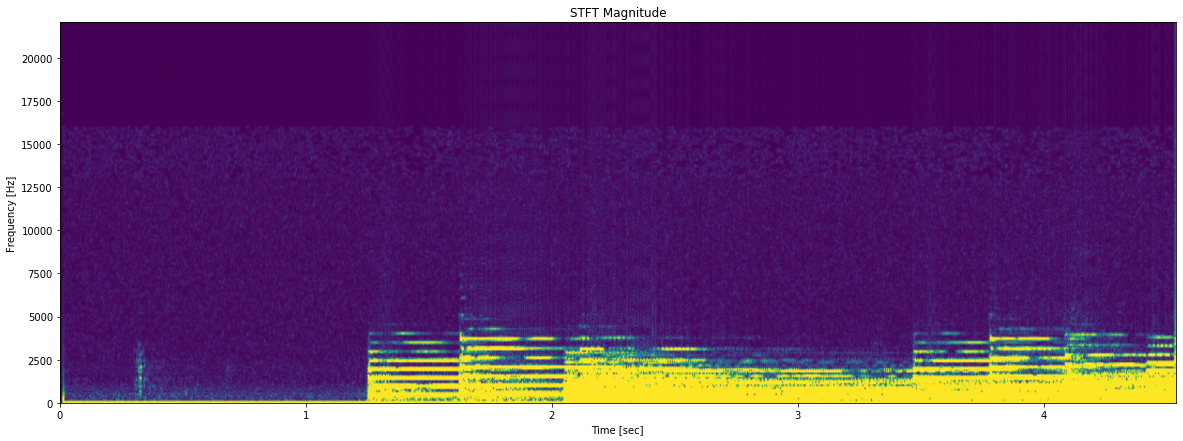

In [4]:
Viz_Y(Yabs,t ,f)

# Apply NMF :

In [5]:
n_components=2
Yabs[Yabs==0]=0.001
model = NMF(n_components=n_components, init='random',alpha=0.5,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
B = model.fit_transform(Yabs)
G = model.components_

Sources = Reconstruct(n_components, B, G, Yabs)

Source shape = (257, 1043)


In [6]:
s1 = torch.tensor(Sources[0], dtype = torch.double)
s2 = torch.tensor(Sources[1])
Yabs = torch.tensor(Yabs)

 # Learning Loop :

* Define optimizer with all parameters W , x1 , x2 , u , v
* Dataloader gives a batch that we loop accross
* For each sample we feed the network with X1 and then we get f1 
* We feed with X2 and we get f2
* We compute u and v using the function.
* We compute the total loss.
* Loss.back()
* Optimizer step 

# Fix a part of the gradients:

In [ ]:
import numpy as np

x1=torch.tensor(np.zeros((20,10)))
x1.requires_grad = True
d =list(model.parameters())+[s1]+[s2]
optimizer = optim.LBFGS(d,lr=1, max_iter=20, tolerance_grad=1e-07)

In [ ]:
optimizer.zero_grad
a = torch.randn(3,4)

optimizer= SGD([a],lr=1)
print('Before step a = \n{}'.format(a))
a.requires_grad=True
b = torch.mean(1000*a )

b.backward()

# fill zeros into the first row of grad
a.grad.data[:,0:1].fill_(0)
a.grad.data[:,2:].fill_(0)


# the first row does not change due to zero grad
optimizer.step()


print('After step a = \n{}'.format(a))

# Train the DNN :

In [7]:
def gain_params(s1,s2,y):

        l2_s1 = torch.norm(s1.float(),2, None)
                 
        l2_s2 = torch.norm(s2.float(),2, None)
               
        l2_Y = torch.norm(y.float(),2, None)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
def gain_params_vec(s1,s2,y):

        l2_s1 = torch.norm(s1.float().t(),1, True)
                 
        l2_s2 = torch.norm(s2.float().t(),1, True)
               
        l2_Y = torch.norm(y.float().t(),1, True)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v

In [8]:
def feed_(x):
    
    f = model(x)
    f1 = f[0] 
    f2 = f[1]
    return f1,f2

def energy_1(x_source1):
    
    f1,f2 = feed_(x_source1)
    e1 = (1 - f1 ).pow(2) + f2.pow(2)
    return e1 

def energy_2(x_source2):

    f1,f2 = feed_(x_source2)
    e2 = f1.pow(2) + (1 - f2 ).pow(2) 
    return e2

def E_err(s1,s2,y):
  
    u,v = gain_params_vec(s1,s2,y) 
    return torch.norm(torch.mul(u,s1) + torch.mul(v,s2) - y,'fro',None)

def E_err_vec(s1,s2,y,u,v):
  
    return torch.norm(u*s1 + v*s2 - y,'fro',None)


def relu(x):
    return torch.nn.ReLU()(x)

def nonnegative_constraint(s1,s2,y,u,v):  
    
    u_sum  = torch.sum(relu(u))
    v_sum  = torch.sum(relu(v))
    x1_sum = torch.sum(relu(s1))
    x2_sum = torch.sum(relu(s2))
    total_sum = 1 / (u_sum + v_sum + x1_sum + x2_sum)    #vector containing all the unknowns which must all be nonnegative

    return total_sum 


def nonneg_constraint(s1,s2,u,v):
    
    R=min([s1.min().item(),s2.min().item(),u,v,0])
    
    return R**2

In [9]:
u,v = gain_params_vec(s1, s2, Yabs)
u.requires_grad = True
v.requires_grad = True
#print('u0 = {:.2f} , v0 = {:.2f}'.format(u,v)) 

In [10]:
s1.requires_grad = True
s2.requires_grad = True

In [11]:
model = Net(257)
print(model)


Net(
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=257, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=2, bias=True)
)


In [12]:
def Criteria(s1,s2,Yabs,u,v,i) :
    
    # Feed forward and get energy 1 and 2
    e1 = energy_1(s1[:,i].float())
    e2 = energy_2(s2[:,i].float())
    
    # Get least square error :
    e_rr=E_err_vec(s1[:,i], s2[:,i], Yabs[:,i],u[i],v[i])
    
    # Non negative constraint
    R = nonneg_constraint(s1[:,i], s2[:,i], u[i], v[i])
    
    # Compute total Loss :
    
    return e1 + e2 + e_rr + R
    

In [13]:
print(u)

tensor([0.5811, 0.6198, 0.7141,  ..., 0.0362, 0.1411, 0.2300],
       requires_grad=True)


In [14]:
print(v)

tensor([0.4071, 0.3738, 0.2816,  ..., 0.9638, 0.8588, 0.7699],
       requires_grad=True)


In [15]:
print(s1)

tensor([[9.3657e-02, 5.5584e-01, 4.9323e-01,  ..., 7.0224e+01, 1.2766e+02,
         7.2841e+00],
        [1.1358e-01, 3.3973e-01, 1.3937e+00,  ..., 2.4022e+01, 1.4448e+02,
         2.0157e+01],
        [2.6563e-02, 1.0612e-01, 8.0990e-01,  ..., 3.8930e+00, 1.7107e+01,
         5.9150e+00],
        ...,
        [5.9130e-03, 3.6539e-03, 9.1743e-03,  ..., 1.3799e-02, 4.6183e-01,
         9.2825e-01],
        [5.1177e-03, 3.6899e-03, 3.3528e-03,  ..., 5.3776e-03, 2.7714e-01,
         6.1044e-01],
        [4.5721e-03, 4.8982e-03, 6.2913e-03,  ..., 3.5100e-03, 1.5955e-01,
         3.8290e-01]], dtype=torch.float64, requires_grad=True)


In [ ]:
params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= LBFGS(params, lr=0.1, max_iter=20, tolerance_grad=1e-07)

In [ ]:
model.train()
for i in range(s1.shape[1]):
    
    def closure():
        optimizer.zero_grad()
        loss = Criteria(s1,s2,Yabs,u,v,i)
        loss.backward()
        return loss
        
        
    print('step i= {}'.format(i))
    optimizer.step(closure)

In [21]:
params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= SGD(params, lr=0.01)

In [22]:
model.train()

for e in range(5):
    
    loss_e=0.0
    for i in range(s1.shape[1]):

            optimizer.zero_grad()
            loss = Criteria(s1,s2,Yabs,u,v,i)
            loss.backward()
            # fill zeros into the first row of grad
            u.grad.data[:i].fill_(0)
            u.grad.data[i+1:].fill_(0)
            v.grad.data[:i].fill_(0)
            v.grad.data[i+1:].fill_(0)
            s1.grad.data[:,:i].fill_(0)
            s1.grad.data[:,i+1:].fill_(0)
            s2.grad.data[:,:i].fill_(0)
            s2.grad.data[:,i+1:].fill_(0)



            optimizer.step()
            loss_e+=loss
            
    print('Epoch {} , Loss = {:.2f}'.format(e,loss_e/s1.shape[1]))

Epoch 0 , Loss = 45945.14
Epoch 1 , Loss = 32771.05
Epoch 2 , Loss = 33741.61
Epoch 3 , Loss = 25315.19
Epoch 4 , Loss = 26260.61


In [26]:
u.max()

tensor(22.8162, grad_fn=<MaxBackward1>)